In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DNN (Rede neural profunda) com três camadas

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0-dev20210819


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

#Dividiu em dados de validação e dados de treinamento
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

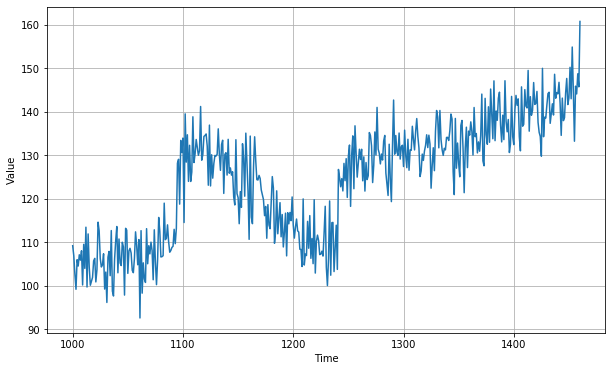

In [6]:
#Dados de validação
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


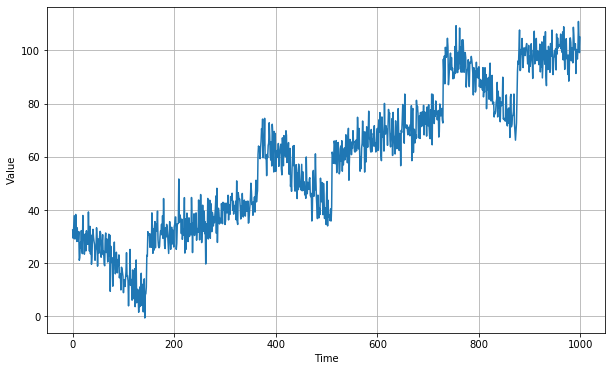

In [7]:
#Dados do treinamento
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)

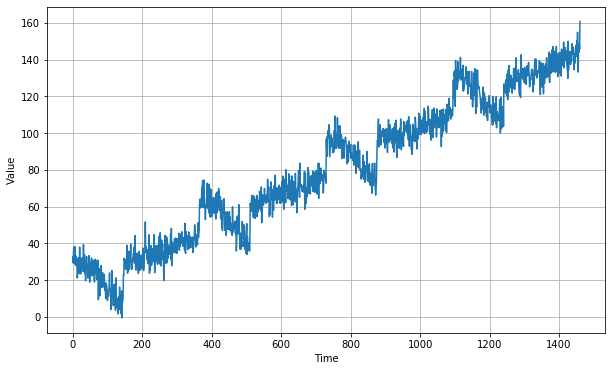

In [10]:
#Dados totais
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
'''DNN'''
# Conjunto de dados de treinamento + tamanho da janela + tamanho do lote + tamanho do buffer aleatório
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Três camadas com:
# 10, 10 e 1 neuronio 
model = tf.keras.models.Sequential([
    # ativar cada camada usando o "relu"
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1) # devolve o valor previsto
])

# compilar com o erro quadratico médio
#e otimizador de descida gradiente estocástico.
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
# treinar com 100 epocas
model.fit(dataset,epochs=100,verbose=0)


/home/bene/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


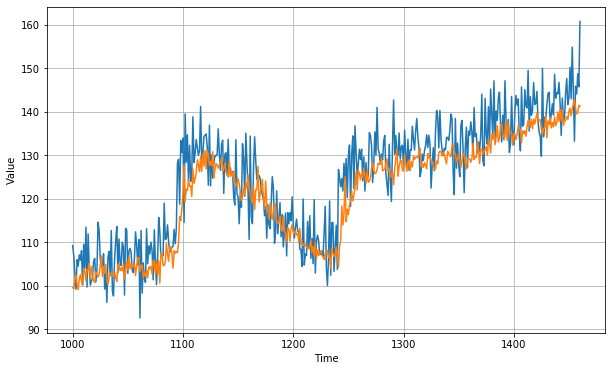

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1821666

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Isso será chamado no retorno de chamada no final de cada época.
''' que isso fará é mudar as taxas de aprendizagem para um valor com base no número da época. Portanto, na época 1, 
é 1 vezes 10 elevado a -8 vezes 10 elevado à potência de 1 sobre 20. E quando chegamos à época 100, será 1 vezes 10 
elevado a -8 vezes 10 elevado à potência de 5, e isso é 100 sobre 20. '''
#vamos treinar novamente mais de 100 épocas, mas vamos usar o código de volta para chamar o programador de taxa de 
#aprendizagem, que ajustará a taxa de aprendizado em cada época.
Reproduza o vídeo começando em :1:35 e siga a transcrição
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
#Isso acontecerá em cada retorno de chamada porque o definimos no parâmetro callbacks (callbacks=[lr_schedule])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

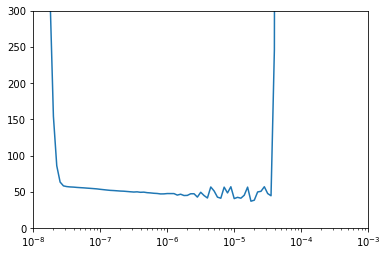

In [16]:
# podemos traçar o último por época contra a taxa de aprendizado por época usando este código, e veremos um gráfico como este
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
#O eixo y nos mostra a perda para aquela época e o eixo x nos mostra a taxa de aprendizado.
#Podemos então tentar escolher o ponto mais baixo da curva onde ainda é relativamente estável assim, e isso é cerca de 7 vezes 10 elevado a -6.
# Ou seja para o proximo podemos mudar a taxa para 'lr=7e-6'
# no caso, o menor numero deu 10^-6 com 1 a frente, então seria 1e-6

In [17]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

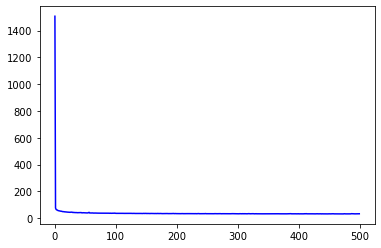

'Que na primeira inspeção parece que provavelmente estamos perdendo nosso tempo treinamento além de talvez apenas 10 épocas, mas é um tanto distorcido pelo fato de que as perdas anteriores foram tão altas'

In [18]:
#Aqui estão os códigos para traçar a perda que foi calculada durante o treinamento,
#podemos ver como a perda progrediu ao longo do tempo de treinamento.
# 
Podemos ver que caiu abruptamente e depois se achatou
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()
'''Que na primeira inspeção parece que provavelmente estamos perdendo nosso tempo treinamento além de talvez apenas 10 épocas, mas é um tanto distorcido pelo fato de que as perdas anteriores foram tão altas'''

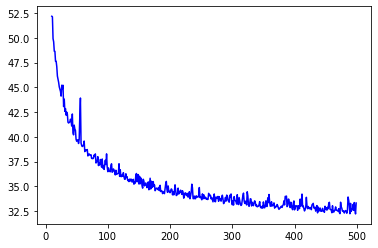

In [20]:
# Plot all but the first 10
# Se os recortarmos e traçarmos a perda para épocas após o número 10 com um código como isso, então o gráfico nos contará uma história diferente.
# se removermos as primeiras dez épocas, veremos as últimas mais claramente e ainda mostra a perda diminuindo suavemente em 500 épocas.
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
#print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()
#Podemos ver que a perda continuava diminuindo mesmo depois de 500 épocas. E isso mostra que nossa rede está aprendendo muito bem

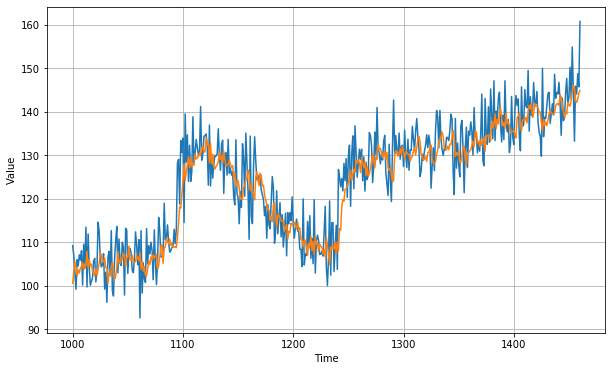

In [21]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.570916

Usando um DNN muito simples, melhoramos nossos resultados muito bem. Mas ainda é apenas um DNN, não há sequenciamento levado em consideração, e em uma série temporal como esta, os valores que estão imediatamente antes de um valor são mais propensos a impactá-lo do que no passado. E essa é a configuração perfeita para usar RNS como tínhamos na linguagem natural curso.